In [2]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import pylab as pl
from shapely.geometry import Point, box, Polygon
from shapely.ops import cascaded_union
import rasterio
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\wb542830\Anaconda3\envs\osm1\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['box', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Working with shapefiles

In [4]:
gdf = gpd.read_file("Ethiopia-RoadNetworkClassification/Road_classificationR.shp")

In [5]:
gdf.head(2)

,OBJECTID_1,OBJECTID,LINK_ID,ROAD_CODE,LENGTH,CLASS,LINK_NAME,REG_R_NAME,REG_R_ID,DESCRIPTIO,...,LENGTH_FRO,LENGTH_F_1,END_CHAINA,START_CHAI,DATA_QUALI,SURFACE_TY,DRIVEABILI,DESIGN_STA,SHAPE_len,geometry
0,1,443,M-B30-1/5,None,0,UC,Baldergit - Chichiki,Baldergit - Chichiki,M-B30-1/5,ARRA Survey,...,26.5,26.946883,26.946883,0.0,None,Un,DW,Unkown,0.242522,"LINESTRING (37.68322 12.78912, 37.68472 12.788..."
1,2,444,M-B30-1/7,None,0,UC,Gedebye - Chilfwenz,Gedebye - Chilfwenz,M-B30-1/7,ARRA Survey,...,5.4,5.398684,5.398684,0.0,None,Un,DW,Unkown,0.048588,"LINESTRING (37.73795 12.87288, 37.73804 12.872..."


In [35]:
gdf.columns

Index(['OBJECTID_1', 'OBJECTID', 'LINK_ID', 'ROAD_CODE', 'LENGTH', 'CLASS',
       'LINK_NAME', 'REG_R_NAME', 'REG_R_ID', 'DESCRIPTIO', 'DATE_SURVE',
       'ADMINISTER', 'LENGTH_FRO', 'LENGTH_F_1', 'END_CHAINA', 'START_CHAI',
       'DATA_QUALI', 'SURFACE_TY', 'DRIVEABILI', 'DESIGN_STA', 'SHAPE_len',
       'geometry'],
      dtype='object')

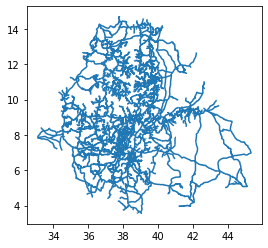

In [11]:
gdf.plot();

#### Extracting bounding box from data

In [25]:
## Displays xmin, ymin, xmax, ymax
bound = gdf.total_bounds
print(bound)

[33.10039593  3.52805    45.34157008 14.7220462 ]


In [22]:
bounding_box = shapely.geometry.box(bound[0], bound[1], bound[2], bound[3])

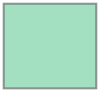

In [24]:
bounding_box

#### Extracting Projection/Coordinate Reference System (CRS)

In [26]:
### Display CRS
print(gdf.crs)

epsg:4326


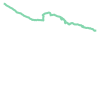

In [33]:
### Display WKT
geom1 = gdf.geometry[0]
geom1

In [89]:
print(geom1.to_wkt())

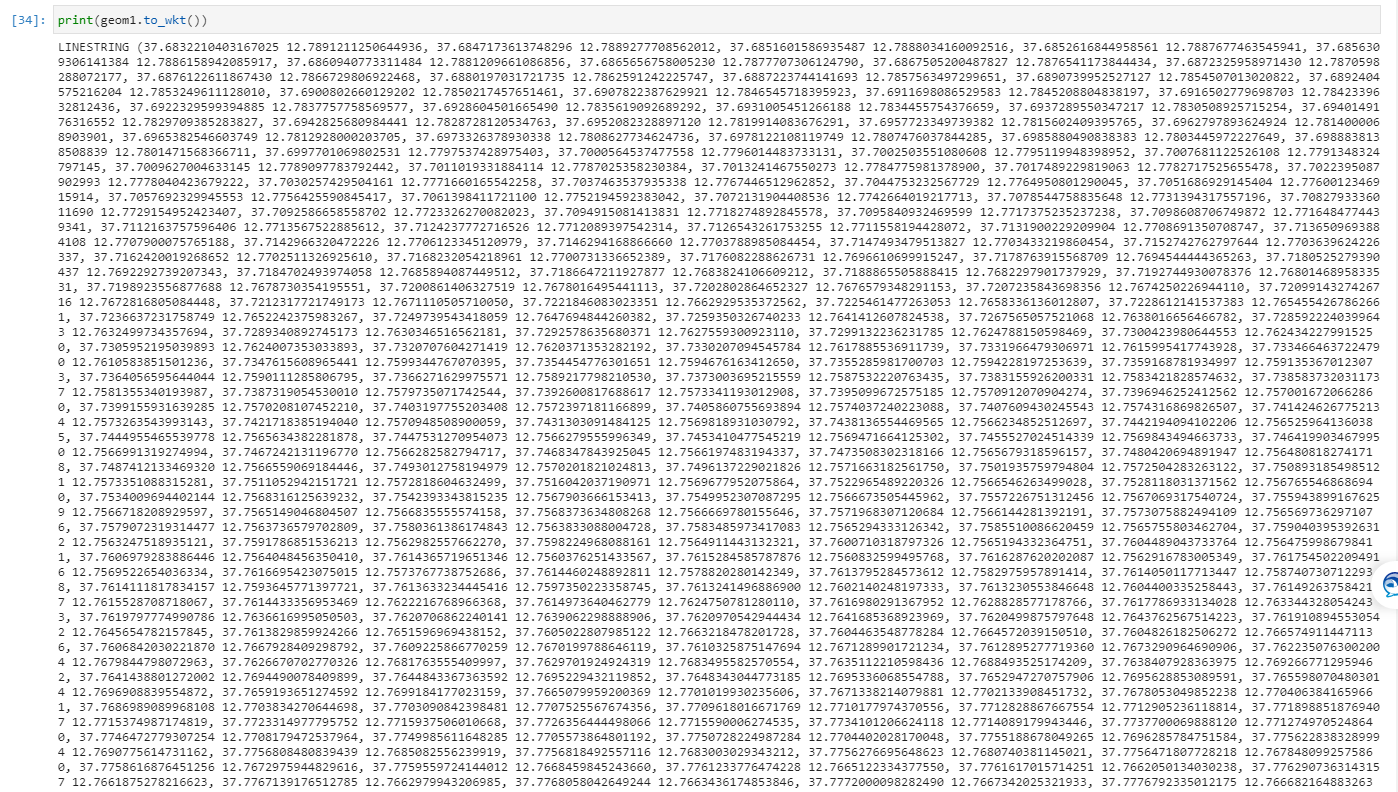

In [96]:
from IPython.display import Image
Image(filename='wkt.PNG')

In [40]:
#### What kind of geometry do we have
gdf.geometry[0].geom_type

'LineString'

In [88]:
#### Exporting a GeoDataFrame to a JSON object
gdf.to_json()

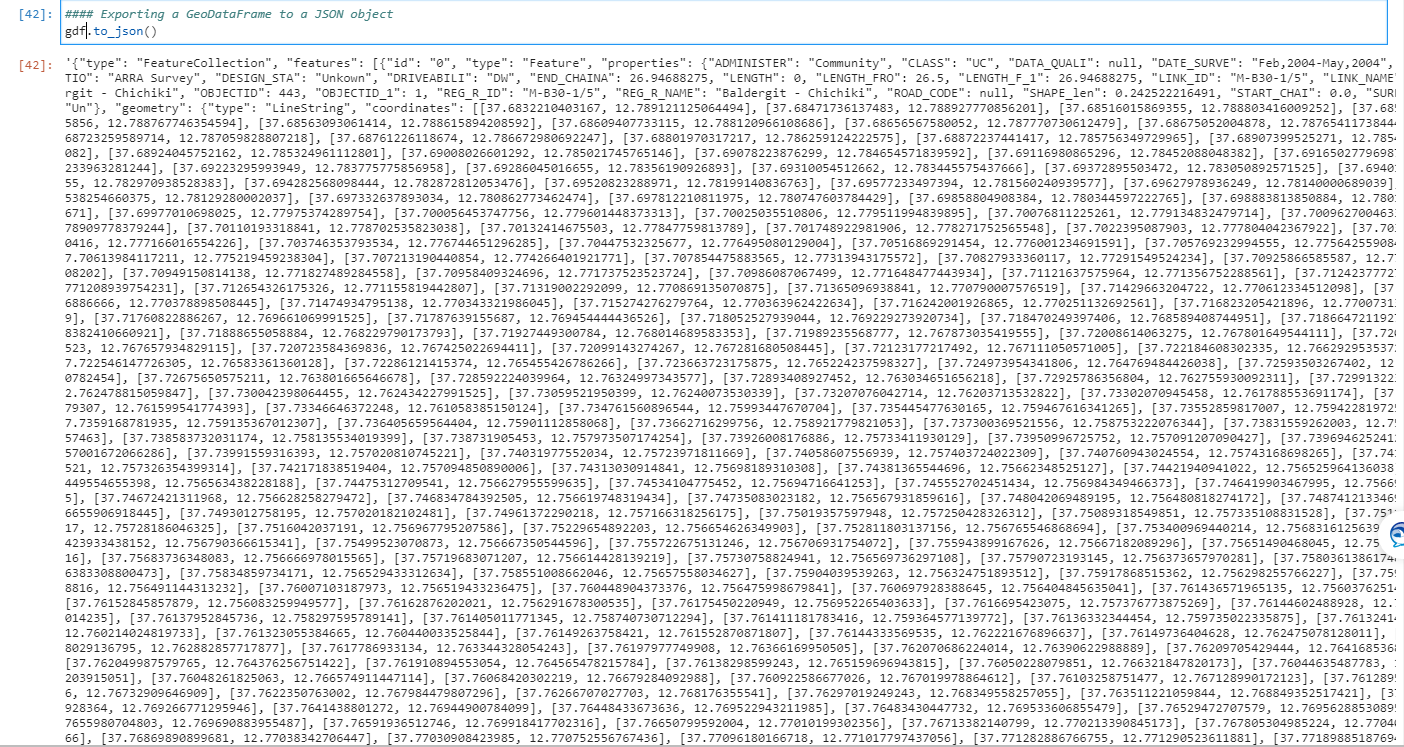

In [97]:
Image('toJS.PNG')

### Working with API / Feature Services

In [45]:
def get_boundaries(attr, val):
    """
    This function queries World Bank official boundary dataset and returns 
    country boundary based on attribute and value passed to the function. 
    
    Input:
    attr: One of the attributes of database
    val : Value corresponding to the attribute
    
    Complete list of attributes can be found here: 
    https://services.arcgis.com/iQ1dY19aHwbSDYIF/ArcGIS/rest/services/World_Bank_Official_Boundaries_World_Country_Polygons_(Very_High_Definition)/FeatureServer/0
    
    Returns:
    A dataframe with features and geometry returned by the API. 
    """
    
    url = ''.join(['https://services.arcgis.com/iQ1dY19aHwbSDYIF/ArcGIS/rest/services/',
            'World_Bank_Official_Boundaries_World_Country_Polygons_(Very_High_Definition)/FeatureServer/0/query?',
            "where={a}='{b}'&f=pjson&returnGeometry=true&outFields=*&outSR=4326".format(a=attr, b=val)])

    result = requests.get(url, verify=False)

    if result.status_code == 200:
        try:
            res = result.json()
            df = pd.DataFrame.from_dict(res['features'][0]).T[:-1]
            geom_lis = []
            for i in range(len(res['features'][0]['geometry']['rings'])):
                geom_lis.append(shapely.geometry.Polygon(res['features'][0]['geometry']['rings'][i]))
            geom = shapely.ops.cascaded_union(geom_lis)
            df.loc['attributes', 'rings'] = geom
            return df
        except Exception as e:
            return e.args[0]

In [46]:
#### We defined a function above that queries a hosted Feature Service on ArcGIS Online and returns the results. 

#### In this step we're querying admin boundaries for Ethiopia

df = get_boundaries('ISO_A3', 'ETH')

C:\Users\wb542830\Anaconda3\envs\osm1\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'services.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [48]:
### type of data returned by the API/Feature Service

type(df)

pandas.core.frame.DataFrame

In [51]:
#### Since the type is currently DataFrame, we need to convert it to GeoDataFrame to leverage spatial functions

df = gpd.GeoDataFrame(df, geometry = 'rings')

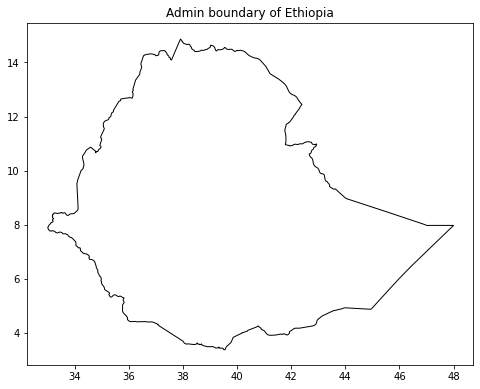

In [58]:
df.plot(color= 'w', edgecolor = 'k', figsize=[8,8] );
pl.title("Admin boundary of Ethiopia", fontsize=12);

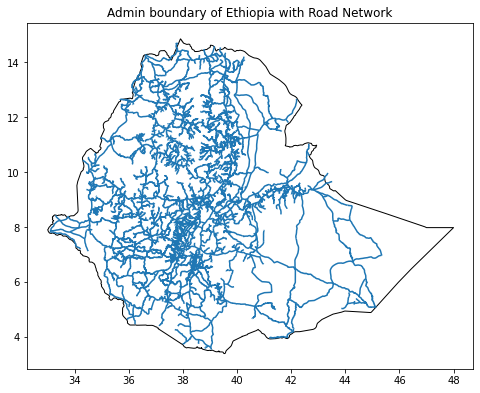

In [59]:
#### Just to see two GeoDataFrames have same projection and fit well, we'll plot them on the same axis

ax = df.plot(color= 'w', edgecolor = 'k' , figsize=[8,8]);
gdf.plot(ax = ax);
pl.title("Admin boundary of Ethiopia with Road Network", fontsize=12);

### Working with Rasters

In [77]:
#### Reading in a raster file

ras = rasterio.open("NYC_training_data.tif")

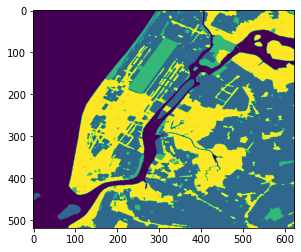

In [79]:
pl.imshow(ras.read()[0,:,:])

#### Extracting Metadata

In [86]:
### Number of bands

ras.count

1

In [80]:
### Dataset Driver
ras.driver

'GTiff'

In [81]:
### Data CRS

ras.crs

CRS.from_epsg(4326)

In [82]:
### Data Affine Transform

ras.transform

Affine(0.00026949458523585647, 0.0, -74.04255931521062,
       0.0, -0.00026949458523585647, 40.818188868993296)

In [84]:
### Coordinates for Coordinates for first (top-left) pixel

ras.transform * (0,0)

(-74.04255931521062, 40.818188868993296)

In [87]:
### Raster's height and width

ras.height, ras.width

(519, 623)

In [85]:
### bounding box

ras.bounds

BoundingBox(left=-74.04255931521062, bottom=40.67832117925589, right=-73.87466418860869, top=40.818188868993296)

In [100]:
### Since its a land cover data, it should have categorical data

ras_arr = ras.read()

np.unique(ras_arr)

array([0, 1, 2, 3], dtype=uint8)

In [101]:
#### Since I created this data I know what these values repreent but Ideally this information should be present in metadata.

## 0 --> Water
## 1 --> Green areas
## 2 --> Urban residential
## 3 --> Urban Non-residential

#### Another raster with more layers

In [104]:
rr = rasterio.open("NYC_test.tif")

In [105]:
rr.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 623, 'height': 519, 'count': 12, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -74.04255931521062,
       0.0, -0.00026949458523585647, 40.818188868993296), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [106]:
rr_arr = rr.read()

In [108]:
for i in rr.shape[0]:
    pl.imshow()

(12, 519, 623)

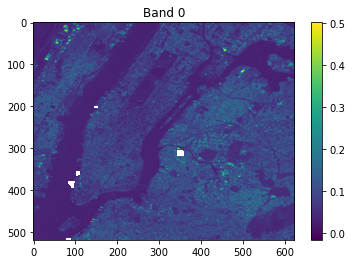

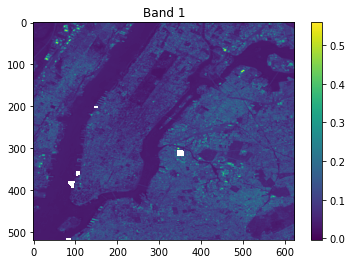

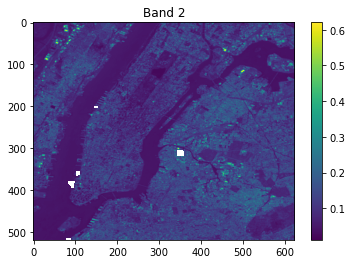

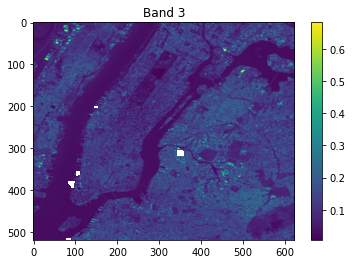

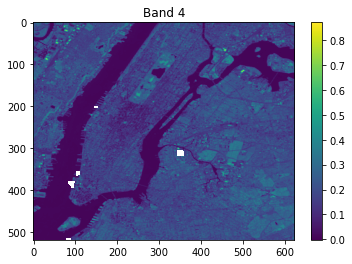

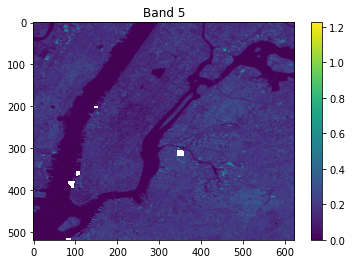

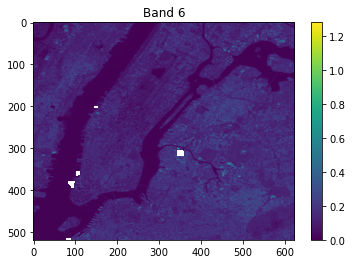

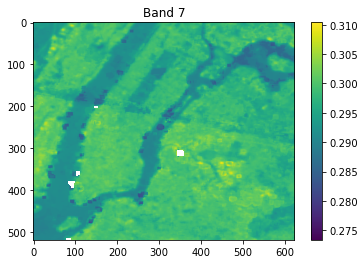

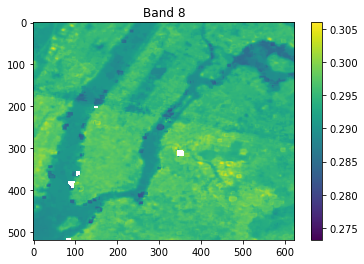

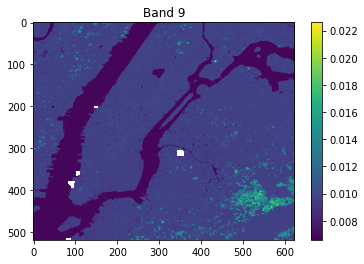

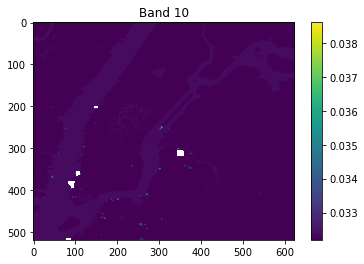

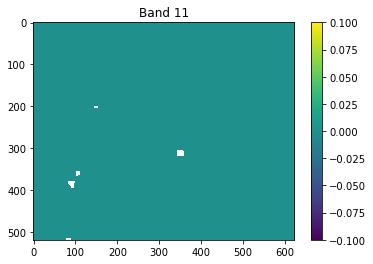

In [120]:
for i in range(rr_arr.shape[0]):
    plt.figure()
    plt.title("Band "+str(i)) # fix dict code then add proper band names
    plt.imshow(rr_arr[i,:,:])
    plt.colorbar()
    plt.show()